In [13]:
import os, shutil
import numpy as np

datadir = '/home/rafael/datasets/new-animal-dataset'

train_dir = datadir + '/training'
validation_dir = datadir + '/validation'
test_dir = datadir + '/test'

train_cats_dir = datadir + '/training/cat/'
train_dogs_dir = datadir + '/training/dog'

validation_cats_dir = datadir + '/validation/cat'
validation_dogs_dir = datadir + '/validation/dog'

test_cats_dir = datadir + '/test/cat'
test_dogs_dir = datadir + '/test/dog'


In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

In [1]:
from keras import layers
from keras import models
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

"""
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
 
model.summary()
"""
conv_base.summary()

Using TensorFlow backend.
/home/rafael/anaconda3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 942s 16us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
__

In [3]:
from keras.models import model_from_json

conv_base.save('VGG16-conv_base.h5')

model_json = conv_base.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 1999 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
def extract_features(directory, sample_count):
    datagen = ImageDataGenerator(rescale=1./255)
    batch_size = 20
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [16]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit(train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6122 - acc: 0.6710 - val_loss: 0.4212 - val_acc: 0.8430
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4193 - acc: 0.7940 - val_loss: 0.3465 - val_acc: 0.8660
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3590 - acc: 0.8365 - val_loss: 0.3125 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 2s 979us/step - loss: 0.3076 - acc: 0.8725 - val_loss: 0.2899 - val_acc: 0.8820
Epoch 5/30
2000/2000 [==============================] - 2s 997us/step - loss: 0.2813 - acc: 0.8885 - val_loss: 0.2756 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 2s 998us/step - loss: 0.2532 - acc: 0.8970 - val_loss: 0.26

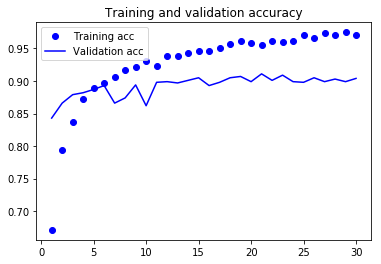

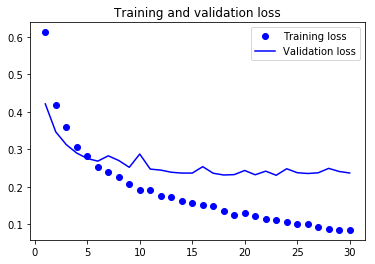

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()